# Medicare Payment Prediction with Amazon SageMaker Autopilot
_**Using AutoPilot to Predict Healthcare Payment Amounts**_

---

---

## Contents

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Data Exploration and Quality Control](#Data-Exploration-and-Quality-Control)
1. [Train](#Settingup)
1. [Autopilot Results](#Results)
1. [Host](#Host)
1. [Cleanup](#Cleanup)

---

## Introduction

Amazon SageMaker Autopilot is an automated machine learning (commonly referred to as AutoML) solution for tabular datasets. You can use SageMaker Autopilot in different ways: on autopilot (hence the name) or with human guidance, without code through SageMaker Studio, or using the AWS SDKs. This notebook, as a first glimpse, will use the AWS SDKs to simply create and deploy a machine learning model. Feature Engineering and hyperparameter tuning can be a laborious process, especially in "messy" dataset, like the one discussed in this notebook. Autopilot will perform the feature engineering and hyperparameter tuning for us.

Predicting payments from insurance providers for healthcare services provided is essential for providers, insurers, and patients. This notebook analzes a 2010 dataset of Medicare payments based on a sample of benificiaries. For more information about this dataset, see [here](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Carrier_Line_Items). For the detailed data dictionary for this dataset, see [here](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/BSAPUFS/Downloads/2010_Carrier_Data_Dictionary.pdf) and [here](https://cpsddr.uahs.arizona.edu/File/Details/656). 


**Notes**: 

* Much of the code and insructions for this notebook is copied/adapted from [this](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/autopilot/autopilot_customer_churn.ipynb) AWS SageMaker example notebook.

* SageMaker Autopilot jobs can be created either via API calls or via SageMaker Studio. This notebook will rely excusivley on creating the jobs via the API interface

* This notebook taks about 1 hour to run; however, You can example the results of a pre-run job in the candidate generation noteook, data exploration notebook, and variable importance report.


## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).




Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [8]:
import pandas 
import matplotlib.pyplot as plt
from time import gmtime, strftime, sleep
from scipy import stats
import sagemaker
import boto3
import seaborn
import os

time: 355 µs (started: 2023-03-13 23:26:00 +00:00)


In [2]:
region = boto3.Session().region_name

sagemaker_session = sagemaker.Session()
BUCKET=sagemaker_session.default_bucket()
PREFIX='autopilot_healthcare_sample' #this is the "directory" path to the file
INPUT_FILE='healthcare_data_sample.csv'
data_location=f's3://{BUCKET}/{PREFIX}/{INPUT_FILE}'

role = sagemaker.get_execution_role()

# This is the client we will use to interact with SageMaker AutoPilot
sm = boto3.Session().client(service_name='sagemaker',region_name=region)

---
## Data
Insurers (including Medicare and Medicaid), maintain records of healthcare payments
The dataset we use is publicly available and is available [here](http://go.cms.gov/19xxPN4 ).

Let's download that dataset now:

Now let's read in the data to a pandas dataframe

In [3]:
healthcare_payment_df = pandas.read_csv("healthcare_data_sample.csv", low_memory=False)
healthcare_payment_df.head()

,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD,CAR_LINE_ICD9_DGNS_CD,CAR_LINE_HCPCS_CD,CAR_LINE_BETOS_CD,CAR_LINE_SRVC_CNT,CAR_LINE_PRVDR_TYPE_CD,CAR_LINE_CMS_TYPE_SRVC_CD,CAR_LINE_PLACE_OF_SRVC_CD,CAR_HCPS_PMT_AMT,CAR_LINE_CNT
0,2,6,794,93510,P2F,1,1,2,11,700,1
1,2,3,781,99316,M4B,1,1,1,31,65,4
2,1,2,429,99203,M1A,1,1,1,11,70,1
3,2,2,296,90817,M5B,1,1,1,51,50,45
4,2,6,427,99233,M2B,1,1,1,21,90,626


The attributes/columns (following verbaitim the data dictionary [here](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/BSAPUFS/Downloads/2010_Carrier_Data_Dictionary.pdf) of this dataset are:

- `BENE_SEX_IDENT_CD`: This field indicates the sex of the beneficiary (Male or Female)
- `BENE_AGE_CAT_CD`: This categorical variable is based on the beneficiary's age at end of the reference year (2010).
- `CAR_LINE_ICD9_DGNS_CD`: The patient’s diagnosis associated with each line item
- `CAR_LINE_HCPCS_CD`: Healthcare Common Procedure Coding System (HCPCS) codes to identify items and services
- `CAR_LINE BETOS_CD`: The Berenson‐Eggers Type of Service (BETOS) code for the line item based on generally agreed upon clinically meaningful groupings of procedures and
services.
- `CAR_LINE_PRVDR_TYPE_CD`: Identifies the type of provider furnishing the service for the line item.
- `CAR_LINE_SRVC_CNT`:  Provides the count of the total number of services processed for the line
item
- `CAR_LINE_CMS_TYPE_SRVC_CD`: Indicates the type of service for the line item
- `CAR_LINE_PLACE_OF_SRVC_CD`: The place of service for the line item.
- `CAR_HCPCS_PMT_AMT`: Contains the payment made by Medicare for the line item. The values are provided after rounding to the nearest unit
- `CAR_LINE_CNT`: Contains the number of carrier line items associated with each profile

The attribute `CAR_HCPCS_PMT_AMT`, is known as the target attribute or response variable–the attribute that we want the ML model to predict.


Note an important aspect of this dataset is that it is of mixed-types. Some columns (e.g. `CAR_LINE_BETOS_CD`) are strings, while others (e.g. `BENE_AGE_CAT_CD`) are numeric but categorical; others (e.g. `CAR_LINE_SRVC_CNT`) are cardinal. Manually processing these different feature types is time consuming; **Autopilot will perform this preprocessing for us**.


### Reserve some data for calling inference on the model

Divide the data into training and testing splits. The training split is used by SageMaker Autopilot. The testing split is reserved to perform inference using the suggested model.

In [4]:
train_data = healthcare_payment_df.sample(frac=0.8,random_state=200)
test_data = healthcare_payment_df.drop(train_data.index)
test_data_no_target = test_data.drop(columns=['CAR_HCPS_PMT_AMT'])

Now we'll upload these files to S3.

In [5]:
s3 = boto3.resource('s3')

train_file = 'train_data.csv'
train_data.to_csv(train_file, index=False, header=True)
s3.meta.client.upload_file(train_file, BUCKET, PREFIX+"/"+train_file)

test_file = 'test_data.csv'
test_data_no_target.to_csv(test_file, index=False, header=False)
s3.meta.client.upload_file(test_file, BUCKET, PREFIX+"/"+test_file)

## Kick of the SageMaker Autopilot job.
We will now kick of the SageMaker Autopilot job. SageMaker Autopilot will take care of the feature engineering, testing, and model tuning for us in a fully automated fashion. A schematic of how Autopilot handles this shown below:

![alt text](img/autopilot_schematic.png "Autopilot Schematic")

Autopilot will generate the following three outputs:

1. Autogenerated code corresponding to feature transformations and ML candidates.
2. Autogenerated code corresponding to basic exploratory data analysis.
3. Feature explanability based on [SHAP values](https://aws.amazon.com/blogs/machine-learning/explaining-amazon-sagemaker-autopilot-models-with-shap/).
4. The ML model candidates. 

Autopilot takes about an hour to run this analysis, but you can explore the **pre-computed** notebooks now if you wish.



In [14]:
#Configure the Autopilot Job
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train_data.csv'.format(BUCKET,PREFIX)
        }
      },
      'TargetAttributeName': 'CAR_HCPS_PMT_AMT'
    }
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(BUCKET,PREFIX)
  }
auto_ml_job_config={'CompletionCriteria':{'MaxAutoMLJobRuntimeInSeconds': 900},
                    "Mode":'ENSEMBLING' #change to HYPERPARAMETER_TUNING if your dataset is large (or auto)
                   }
                                      
#Create the Job
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

auto_ml_job_name = 'automl-health-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig=auto_ml_job_config,
                      ProblemType='Regression',
                      AutoMLJobObjective={ 'MetricName': 'MSE'},
                      RoleArn=role,
                     GenerateCandidateDefinitionsOnly=False)

print ('JobStatus - Secondary Status')
print('------------------------------')


#Track the job progress
describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)
    


AutoMLJobName: automl-health-13-23-32-25
JobStatus - Secondary Status
------------------------------
InProgress - Starting
InProgress - Starting
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - MaxAutoMLJobRuntimeReached
Com

In [15]:
best_candidate=sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
best_candidate_name = best_candidate['CandidateName']
#Next we will find the best candidate created by Autopilot . 
#Feel free to further explore more the candidate generation notebook, data exploration notebook, 
# and the feature explanability notebook. 

#Copy Over the candidate generation and data exploration notebooks, if using HYPERPARAMETER_TUNING mode

#
#print(best_candidate)
#print('\n')
#print("CandidateName: " + best_candidate_name)
#print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
#print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))
    
#candidate_generation_notebook=describe_response['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation']
#os.system(f'''aws s3 cp {candidate_generation_notebook} .''')
#data_exploration_notebook=describe_response['AutoMLJobArtifacts']['DataExplorationNotebookLocation']
#os.system(f'''aws s3 cp {data_exploration_notebook} .''')
##download the shap report
#os.system(f'''aws s3 cp {best_candidate["CandidateProperties"]['CandidateArtifactLocations']['Explainability']}/{best_candidate_name}/report.ipynb .''')


time: 209 ms (started: 2023-03-13 23:54:36 +00:00)


In [9]:
#sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

## Create a Batch Transformation Job
SageMaker supports many different ways to do [model deployments](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-deployment.html). For this job, we will deploy the model as a [Batch Transformation](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html).

In [10]:
model_name = 'automl-healthcare-model-' + timestamp_suffix

model = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN corresponding to the best candidate is : {}'.format(model['ModelArn']))

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:us-west-2:111918798052:model/automl-healthcare-model-13-19-09-03


In [11]:
test_data_s3_path=f's3://{BUCKET}/{PREFIX}/test_data.csv'
transform_job_name = 'automl-health-transform-' + timestamp_suffix + 'v2'

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': test_data_s3_path
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': 's3://{}/{}/inference-results'.format(BUCKET,PREFIX),
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }

sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources
)

{'TransformJobArn': 'arn:aws:sagemaker:us-west-2:111918798052:transform-job/automl-health-transform-13-19-09-03v2',
 'ResponseMetadata': {'RequestId': '323f0cb7-dcc0-4946-871d-11b102bd042d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '323f0cb7-dcc0-4946-871d-11b102bd042d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '114',
   'date': 'Mon, 13 Mar 2023 19:25:11 GMT'},
  'RetryAttempts': 0}}

In [12]:
print ('JobStatus')
print('----------')


describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print(job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print(job_run_status)
    sleep(30)

JobStatus
----------
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [13]:
out = 'test_data.csv.out'
boto3.client('s3').download_file(BUCKET, os.path.join(PREFIX, 'inference-results', out), out)

## Test Model Performance
**After** you have have deployed a model based on the candidates generated by autopilot (which you can see in the autogenerated candidate definition notebook), it will return the name of the endpoint created. We will now test the endpoint performance on the test data

In [14]:
predictions_df=pandas.read_csv('test_data.csv.out',header=None)
predictions_df=pandas.concat([predictions_df.reset_index()[0],test_data.reset_index()['CAR_HCPS_PMT_AMT']],axis=1,ignore_index=True)
predictions_df.columns=["Prediction","True"]

In [15]:
predictions_df.head()

,Prediction,True
0,56.473877,70
1,244.381241,50
2,376.270386,375
3,26.062897,35
4,90.712082,75


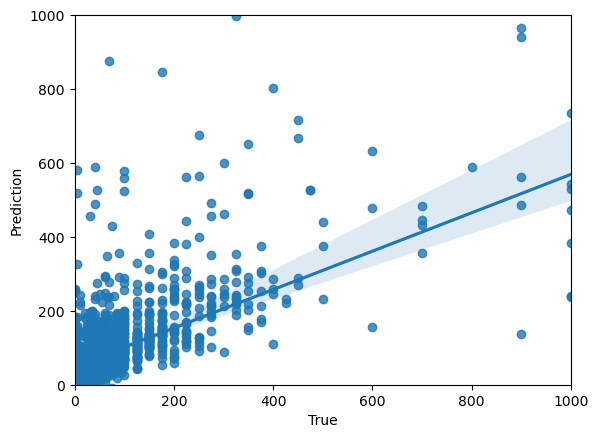

In [16]:
ax=seaborn.regplot(x=predictions_df["True"], y=predictions_df["Prediction"])
ax.set(ylim=(0, 1000),xlim=(0,1000))
plt.show()

Let's measure the statistical significance and Spearman Rho.

In [17]:
#Get the Spearman Rho
spearman_rho=stats.spearmanr(predictions_df['Prediction'],predictions_df["True"])[0]
spearman_rho_p=stats.spearmanr(predictions_df['Prediction'],predictions_df["True"])[1]

print(f'''Spearman Rho: {spearman_rho}''')
print(f'''P-value: {spearman_rho_p}''')

Spearman Rho: 0.7030273860661523
P-value: 4.34999974451135e-298


We can see that there is a clear, statistically very significant positive correlation between the predicted payment amount and the true payment amount. Of course, the model is not perfect; examining and modifying the feature engineering and hyper parameter tuning notebook generated by autopilot might even futher improve performance.